# eXponential Family Dynamical Systems (XFADS): Large-scale nonlinear Gaussian state-space modeling

For a first simple glance of XFADS, we start with a walk-through example to explore its minimal functioning by applying it to synthesized data from a linear dynamical system.<br>
If you feel comfortable dabbling with XFADS by directly applying it to neural data, you can jump directly to the MC_Maze example.<br>

For an in-depth understanding of the underlying theory of this statistical framework, dive into the paper: [Dowling, Zhao, Park. 2024](https://arxiv.org/abs/2403.01371). But if you are more into practicality and neural data analysis, it's enough to start with the examples.

## Installation
After cloning the repo, and installing anaconda, or miniconda, create the environment by running:<br>
`conda env create -f environment.yaml`<br>

Add the `xfads` package to the `PYTHONPATH` of the environment<br>
`pip install -e .`<br>

If you are on Google Colab, just run the following cell to clone the repo and install the requirements, and you are ready to go!<br>
(Since Colab uses sessions anyway, it won't be that useful to use an environment.)

In [5]:
def is_running_in_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_running_in_colab():
    !git clone https://github.com/catniplab/xfads.git
    %cd xfads
    !pip install torch pytorch-lightning scikit-learn hydra-core matplotlib einops
    !pip install pyproject.toml -e .

In [7]:
import math
import torch
import torch.nn as nn
import pytorch_lightning as lightning
import matplotlib.pyplot as plt
import hydra

import xfads.utils as utils
import xfads.plot_utils as plot_utils

from matplotlib import cm
from scipy.ndimage import gaussian_filter1d
from hydra import compose, initialize

from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint

import lds_utils

from xfads.ssm_modules.dynamics import DenseGaussianDynamics
from xfads.ssm_modules.likelihoods import GaussianLikelihood
from xfads.smoothers.lightning_trainers import LightningNonlinearSSM
from xfads.ssm_modules.dynamics import DenseGaussianInitialCondition
from xfads.ssm_modules.encoders import LocalEncoderLRMvn, BackwardEncoderLRMvn
from xfads.smoothers.lightning_trainers import LightningNonlinearSSM, LightningDMFCRSG
from xfads.smoothers.nonlinear_smoother_causal import NonlinearFilter, LowRankNonlinearStateSpaceModel

In [8]:
torch.cuda.empty_cache()

## Set up the configuration
All in the `config.yaml` file, where you can tune the model parameters.

In [12]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="", job_name="lds")

cfg = compose(config_name="config")
lightning.seed_everything(cfg.seed, workers=True)
torch.set_default_dtype(torch.float32)

Seed set to 1234


## Generating the data
For this example, we will use data that is synthesized from the Vanderpol oscillator, which is a classic mathematical model that describes self-sustained oscillations observed in various physical systems. Then we will infer the posterior distribution of the latent factors that govern the low-dimensional underlying dynamics of the data, by learning a graphical state space model of the principal latent and the observations.

In [15]:
# n_trials x n_time_bins x n_neurons

"""generate data -- 2d oscillator with decay"""
n_trials = 500
n_neurons = 100
n_time_bins = 100

A = nn.Linear(cfg.n_latents, cfg.n_latents, bias=False, device=cfg.device)
A.weight.data = 0.9 * utils.make_2d_rotation_matrix(math.pi/4, device=cfg.device)
C = nn.Linear(cfg.n_latents, n_neurons, bias=True, device=cfg.device).requires_grad_(False)
Q_0_diag = torch.ones(cfg.n_latents, device=cfg.device)
Q_diag = torch.ones(cfg.n_latents, device=cfg.device)
R_diag = torch.ones(n_neurons, device=cfg.device)
m_0 = torch.zeros(cfg.n_latents, device=cfg.device)

z = utils.sample_gauss_z(A, Q_diag, m_0, Q_diag, n_trials, n_time_bins)
y = C(z) + torch.sqrt(R_diag) * torch.randn((n_trials, n_time_bins, n_neurons), device=cfg.device)
y = y.detach()

y_train, z_train = y[:n_trials//2], z[:n_trials//2]
y_valid, z_valid = y[n_trials//2:], z[n_trials//2:]

y_train_dataset = torch.utils.data.TensorDataset(y_train,)
y_valid_dataset = torch.utils.data.TensorDataset(y_valid,)
train_dataloader = torch.utils.data.DataLoader(y_train_dataset, batch_size=cfg.batch_sz, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(y_valid_dataset, batch_size=cfg.batch_sz, shuffle=True)

In [17]:
# Indixes of n example trials
ex_trials = lds_utils.gen_unique_rand_ints(0, y_valid.shape[0]-1, n=4)

# Indixes of n example neuron
ex_neurons = lds_utils.gen_unique_rand_ints(0, y_valid.shape[1]-1, n=4)

# top n neurons to plot with visualizing trials
top_n_neurons = n_neurons

<Figure size 1600x600 with 0 Axes>

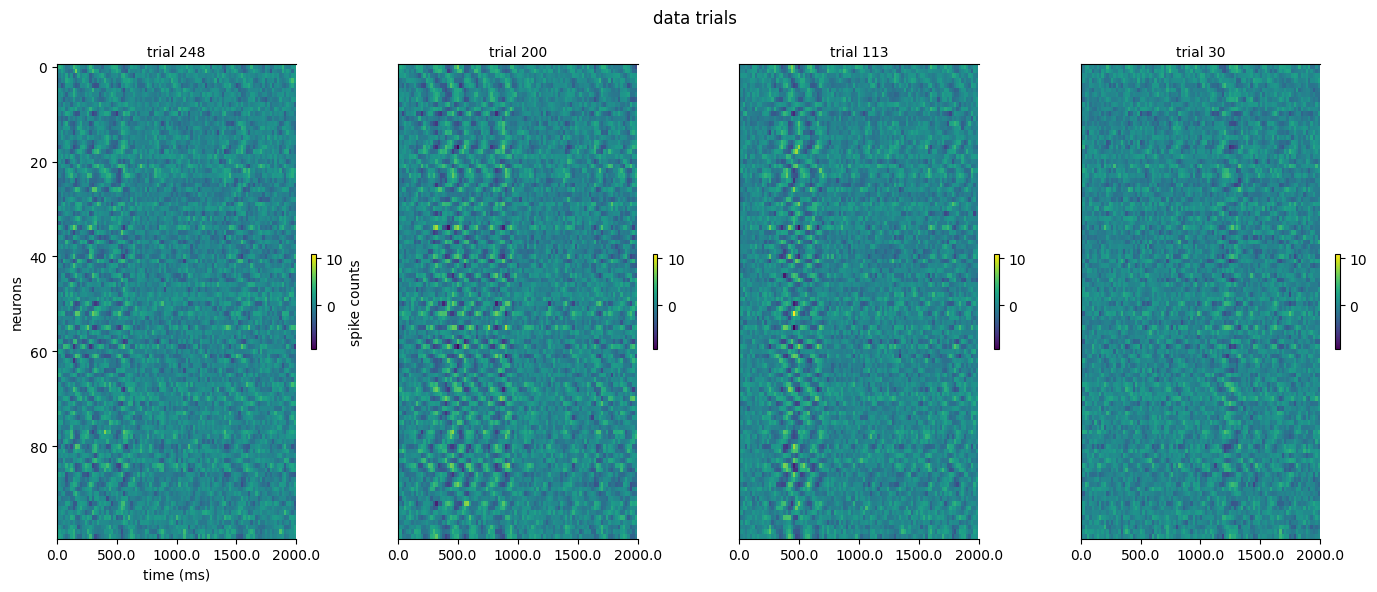

In [19]:
lds_utils.plot_rastor(y_valid, ex_trials, top_n_neurons, cfg)

## Structuring the state-space model
The modules of the XFADS package is organized in a modular way, so that it allows the users to change and plug in their own definitions of the classes that structure the elements of the model, i.e. the dynamics function, the likelihood density, the amortization network, etc.

The configuration depends on the problem - `dynamics_mod`, `initial_c_pdf`, `likelihood_pdf`, `local_encoder`, and `backward_encoder` can be configured as desired. We include some general classes in `ssm_modules/encoders`, `ssm_modules/likelihoods` and `ssm_modules/dynamics` that should be sufficient for a wide range of problems.  Below is an example configuration.

In [23]:
"""likelihood pdf"""
likelihood_pdf = GaussianLikelihood(C, n_neurons, R_diag, device=cfg.device)

"""dynamics module"""
dynamics_fn = utils.build_gru_dynamics_function(cfg.n_latents, cfg.n_hidden_dynamics, device=cfg.device)
dynamics_mod = DenseGaussianDynamics(dynamics_fn, cfg.n_latents, Q_diag, device=cfg.device)

"""initial condition"""
initial_condition_pdf = DenseGaussianInitialCondition(cfg.n_latents, m_0, Q_0_diag, device=cfg.device)

"""local/backward encoder"""
backward_encoder = BackwardEncoderLRMvn(cfg.n_latents, cfg.n_hidden_backward, cfg.n_latents,
                                        rank_local=cfg.rank_local, rank_backward=cfg.rank_backward,
                                        device=cfg.device)
local_encoder = LocalEncoderLRMvn(cfg.n_latents, n_neurons, cfg.n_hidden_local, cfg.n_latents, rank=cfg.rank_local,
                                  device=cfg.device, dropout=cfg.p_local_dropout)
nl_filter = NonlinearFilter(dynamics_mod, initial_condition_pdf, device=cfg.device)

"""sequence vae"""
ssm = LowRankNonlinearStateSpaceModel(dynamics_mod, likelihood_pdf, initial_condition_pdf, backward_encoder,
                                      local_encoder, nl_filter, device=cfg.device)

"""lightning"""
seq_vae = LightningNonlinearSSM(ssm, cfg)
# seq_vae = LightningNonlinearSSM.load_from_checkpoint('ckpts/epoch=471_valid_loss=14513.6044921875.ckpt', ssm=ssm, cfg=cfg)

csv_logger = CSVLogger('logs/', name=f'r_y_{cfg.rank_local}_r_b_{cfg.rank_backward}', version='noncausal')
ckpt_callback = ModelCheckpoint(save_top_k=3, monitor='valid_loss', mode='min', dirpath='ckpts/',
                                filename='{epoch:0}_{valid_loss}')

# Show model structure
seq_vae

LightningNonlinearSSM(
  (ssm): LowRankNonlinearStateSpaceModel(
    (nl_filter): NonlinearFilter(
      (dynamics_mod): DenseGaussianDynamics(
        (mean_fn): DynamicsGRU(
          (gru_cell): GRUCell(0, 64)
          (h_to_z): Linear(in_features=64, out_features=2, bias=True)
          (z_to_h): Linear(in_features=2, out_features=64, bias=True)
        )
      )
      (initial_c_pdf): DenseGaussianInitialCondition()
    )
    (dynamics_mod): DenseGaussianDynamics(
      (mean_fn): DynamicsGRU(
        (gru_cell): GRUCell(0, 64)
        (h_to_z): Linear(in_features=64, out_features=2, bias=True)
        (z_to_h): Linear(in_features=2, out_features=64, bias=True)
      )
    )
    (local_encoder): LocalEncoderLRMvn(
      (mlp): Sequential(
        (0): Linear(in_features=100, out_features=128, bias=True)
        (1): SiLU()
        (2): Dropout(p=0.4, inplace=False)
        (3): Linear(in_features=128, out_features=6, bias=True)
      )
    )
    (initial_c_pdf): DenseGaussianInit

In [25]:
trainer = lightning.Trainer(max_epochs=cfg.n_epochs,
                            gradient_clip_val=1.0,
                            default_root_dir='lightning/',
                            callbacks=[ckpt_callback],
                            logger=csv_logger
                            )

trainer.fit(model=seq_vae, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)
torch.save(ckpt_callback.best_model_path, 'ckpts/best_model_path.pt')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/envs/xfads/lib/python3.9/site-packages/lightning_fabric/loggers/csv_logs.py:268: Experiment logs directory logs/r_y_2_r_b_2/noncausal exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/opt/anaconda3/envs/xfads/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/mahmoud/catnip/xfads/workshop/lds_example/ckpts exists and is not empty.

  | Name | Type                            | Params
---------------------------------------------------------
0 | ssm  | LowRankNonlinearStateSpaceModel | 41.3 K
---------------------------------------------------------
41.0 K    Trainable params
300       Non-trainable params
41.3 K    Total params
0.165     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/anaconda3/envs/xfads/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/opt/anaconda3/envs/xfads/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/opt/anaconda3/envs/xfads/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


## Loading the trained model

In [63]:
seq_vae = LightningNonlinearSSM.load_from_checkpoint(f'ckpts/epoch=248_valid_loss=14963.873046875.ckpt', ssm=ssm, cfg=cfg)

## Evaluating the model
First, let's compare the latents inferred by XFADS, from the data, with the original two dimensions of the dynamical system that was used to generate the data. 

In [115]:
loss, z, stats = seq_vae.ssm(y_valid, cfg.n_samples)

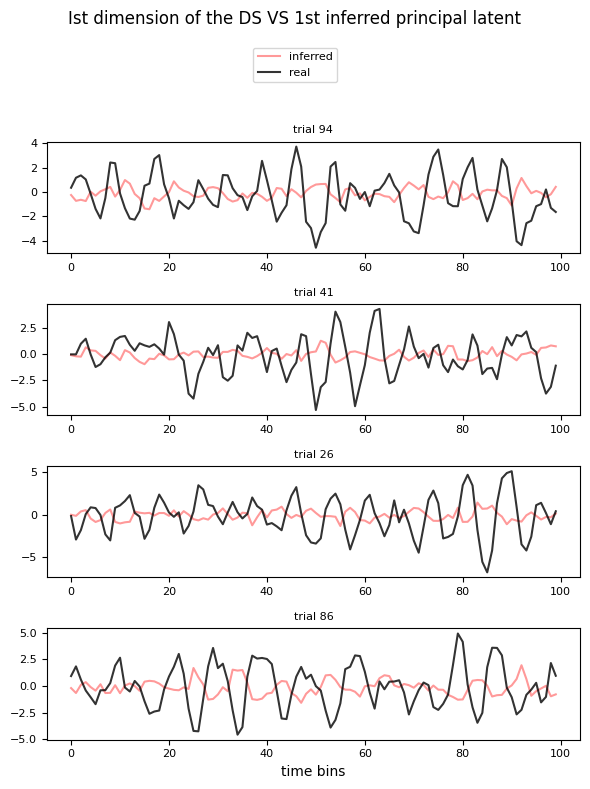

In [177]:
with torch.no_grad():
    
    ex_trials = lds_utils.gen_unique_rand_ints(0, y_valid.shape[1]-1, n=4)
    
    fig, axes = plt.subplots(len(ex_trials), 1, figsize=(6, 8))

    fig.suptitle(f'Ist dimension of the DS VS 1st inferred principal latent\n\n\n\n')
    
    for i, ax in enumerate(axes.flat):    

        ax.plot(stats['m_f'][i, :, 0], color='red', alpha=0.4, label='inferred' if i == 0 else '')
        ax.plot(z_valid[i, :, 0], color='black', alpha=0.8, label='real' if i == 0 else '')
        
        ax.set_title(f'trial {ex_trials[i]}', fontsize=8)
        ax.set_xlabel('time bins' if i == len(ex_trials)-1 else '')
        #ax.set_ylabel('1st dim' if i == 0 else '')
        ax.tick_params(axis='x', labelsize=8)
        ax.tick_params(axis='y', labelsize=8)
    
    plt.tight_layout()
    
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.94), ncol=1, fontsize=8)
    
    plt.show()

In [83]:
z.shape

torch.Size([5, 250, 100, 2])

In [90]:
stats['m_f'].shape

torch.Size([250, 100, 2])

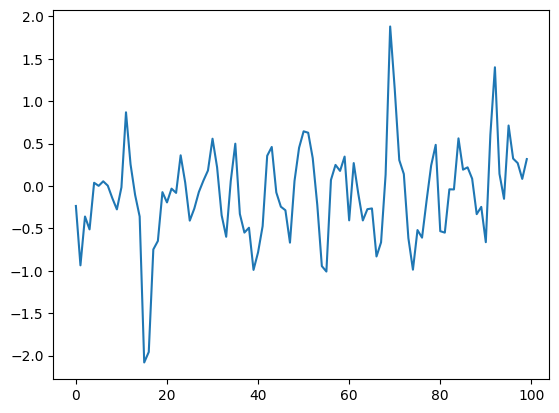

In [100]:
with torch.no_grad():
    plt.plot(stats['m_f'][0, :, 0])

IndexError: index 85 is out of bounds for dimension 2 with size 2

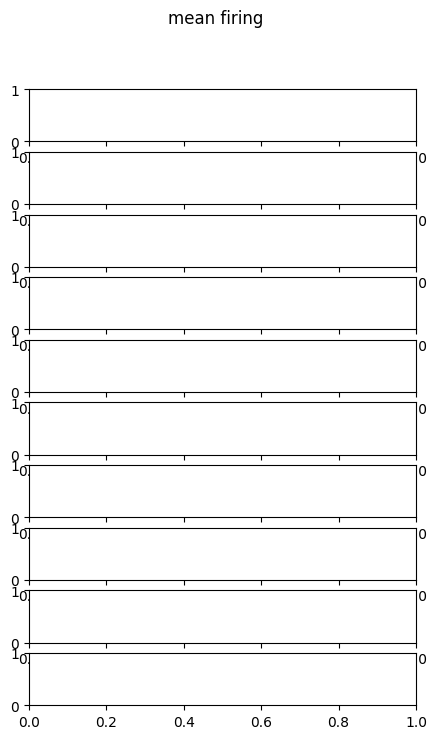

In [92]:
with torch.no_grad():
    
    ex_neurons = lds_utils.gen_unique_rand_ints(0, y_valid.shape[1]-1, n=10)
    
    fig, axes = plt.subplots(len(ex_neurons), 1, figsize=(5, 8))

    fig.suptitle(f'mean firing\n\n\n\n')
    
    for i, ax in enumerate(axes.flat):    

        ax.plot(
            torch.mean(stats['m_f'][:, :, ], dim=0),
            label='smoothed' if i == 0 else '')
        
        ax.plot(
            torch.mean(stats['m_f'][:, :, ex_neurons[i]], dim=0),
            label='predicted' if i == 0 else '')
        
        ax.set_title(f'latents {latent1}, {latent2}, {latent3}', fontsize=8)
    
    plt.tight_layout()

    fig.subplots_adjust(hspace=0.6)  # Increase spacing between subplots
    
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.94), ncol=1, fontsize=6)
    
    plt.show()

/var/folders/py/p6knbk5d2qzdvstddyrnfym80000gn/T/ipykernel_22830/4148023273.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


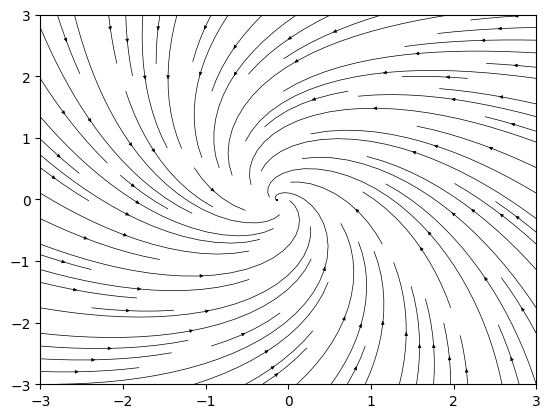

In [66]:
fig, axs = plt.subplots()
plot_utils.plot_two_d_vector_field(seq_vae.ssm.dynamics_mod.mean_fn, axs)
fig.show()